<a href="https://colab.research.google.com/github/Emaan-Malik15/DIP_Project/blob/main/notebook4ad304b558.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dipdata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5241863%2F8732700%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T043129Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7496b67afe6c7c25518d39cd60a3fc7d7ecdeb4e7107dec53eb16f42fd152c04c14b67b9ac3e873e2fdc6031e78f0eaaf6ff18fcd8efd48b1c7edcd0afdbb57acc94c89cdfbf0da885a73f3b10edfb7be837c9b48a9a571fb3e277bec88a104251cbc82382b3629d22ab272adb0428c67c6e1d7a9f2036cbf5971c70dba4c85ffba3c3caf54adefbbb86013c526b7acaeedf0bcf9f7a5c276e74e5f2405433cb944bb524c88a824bf524cc194457a211ac1567181aa8c2761d1f642bf4c73494fd4da5ea18590cb8efc4ad8d6c13e4bbb33d3db5567946a48ca568deb1653bc1229c9421c6e1431022261433abdb549c72894346a7ee25b8ede305531bc0db31'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Import necessary libraries

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2

# Define file paths

In [ ]:
base_path = '/kaggle/input/dipdata/Dipdata'  # Change to your dataset path
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')


# Define parameters

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Function to load and preprocess images

In [ ]:
def load_images(image_paths, img_height, img_width, img_channels):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        if image is None:
            print(f'Warning: Image at path {path} could not be read')
            continue
        image = cv2.resize(image, (img_height, img_width))
        images.append(image)
    if not images:
        print('Warning: No images were loaded.')
    images = np.array(images).astype('float32') / 255.0
    return images

# Function to load masks

In [ ]:
def load_masks(mask_paths, img_height, img_width):
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path, 0)  # Read mask in grayscale
        if mask is None:
            print(f'Warning: Mask at path {path} could not be read')
            continue
        mask = cv2.resize(mask, (img_height, img_width))
        mask = np.expand_dims(mask, axis=-1)
        masks.append(mask)
    if not masks:
        print('Warning: No masks were loaded.')
    masks = np.array(masks).astype('float32') / 255.0
    return masks


# Load dataset

In [ ]:
def load_dataset(base_path):
    categories = ['safe', 'GUN', 'knife', 'shuriken']
    images = []
    labels = []
    masks = []

    for category in categories:
        image_dir = os.path.join(base_path, category)
        if not os.path.isdir(image_dir):
            print(f'Warning: Directory {image_dir} does not exist')
            continue

        image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]

        images.extend(load_images(image_paths, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

        if category.lower() == 'safe':
            labels.extend([0] * len(image_paths))
            # Add dummy masks for 'safe' category
            masks.extend([np.zeros((IMG_HEIGHT, IMG_WIDTH, 1)) for _ in range(len(image_paths))])
        else:
            labels.extend([1] * len(image_paths))
            # Find corresponding mask directory regardless of case
            annotations_dir = os.path.join(base_path, 'annotations')
            if os.path.isdir(annotations_dir):
                mask_dir = next((os.path.join(annotations_dir, folder)
                                 for folder in os.listdir(annotations_dir)
                                 if folder.lower() == category.lower()), None)
                if mask_dir and os.path.isdir(mask_dir):
                    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]
                    masks.extend(load_masks(mask_paths, IMG_HEIGHT, IMG_WIDTH))
                else:
                    print(f'Warning: Annotations folder not found for category {category}')
            else:
                print(f'Warning: Annotations directory {annotations_dir} does not exist')

    if not images or not labels or not masks:
        print('Warning: One of the datasets (images, labels, masks) is empty.')

    return np.array(images), np.array(labels), np.array(masks)

# Load training and testing data


In [ ]:
# Load the datasets
X_train, y_train, masks_train = load_dataset(train_path)
X_test, y_test, masks_test = load_dataset(test_path)

# Check if datasets are loaded correctly
if X_train.size == 0 or y_train.size == 0 or masks_train.size == 0:
    raise ValueError("Training dataset is empty.")
if X_test.size == 0 or y_test.size == 0 or masks_test.size == 0:
    raise ValueError("Test dataset is empty.")


# Split validation data from training data

In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
    X_train, y_train, masks_train, test_size=0.1, random_state=42)

print(f'Training data: {X_train.shape}, {y_train.shape}, {masks_train.shape}')
print(f'Validation data: {X_val.shape}, {y_val.shape}, {masks_val.shape}')
print(f'Test data: {X_test.shape}, {y_test.shape}, {masks_test.shape}')

Training data: (1750, 128, 128, 3), (1750,), (1750, 128, 128, 1)
Validation data: (195, 128, 128, 3), (195,), (195, 128, 128, 1)
Test data: (508, 128, 128, 3), (508,), (508, 128, 128, 1)


# Define the CNN model for classification

In [ ]:
def create_classification_model(input_shape):
    inputs = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

classification_model = create_classification_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
classification_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,441 (1.61 MB)

 Trainable params: 421,441 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the classification model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming classification_model is your Keras model
classification_checkpoint = ModelCheckpoint('classification_model.keras', save_best_only=True, monitor='val_loss')
classification_early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Example of how you might fit your model
classification_history = classification_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[classification_checkpoint, classification_early_stopping]
)


Epoch 1/50


2024-06-19 20:30:50.948786: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-06-19 20:30:50.948873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-06-19 20:30:50.948883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-06-19 20:30:50.948894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-06-19 20:30:50.948911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-06-19 20:30:50.948932: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-06-19 20:30:50.949007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-06-19 20:30:50.949015: E exte

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8213 - loss: 0.3553

I0000 00:00:1718829054.911969     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8910 - loss: 0.2988

2024-06-19 20:30:56.327975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 3.55353, expected 2.78028
2024-06-19 20:30:56.328028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 4.98131, expected 4.20806
2024-06-19 20:30:56.328038: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32770: 5.01856, expected 4.24531
2024-06-19 20:30:56.328045: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 5.25799, expected 4.48475
2024-06-19 20:30:56.328053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 4.30788, expected 3.53464
2024-06-19 20:30:56.328061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 3.3182, expected 2.54495
2024-06-19 20:30:56.328069: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 4.04127, expected 3.26802
2024-06-19 20:30:56.328076: 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8939 - loss: 0.2954

2024-06-19 20:31:02.284911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.34921, expected 2.46525
2024-06-19 20:31:02.284967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.92983, expected 5.04587
2024-06-19 20:31:02.284978: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.86817, expected 4.98421
2024-06-19 20:31:02.284986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.9159, expected 4.03194
2024-06-19 20:31:02.284994: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.84035, expected 3.95638
2024-06-19 20:31:02.285003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.60006, expected 3.7161
2024-06-19 20:31:02.285011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.34646, expected 3.4625
2024-06-19 20:31:02.285019: E external/local_xla/xla/servi

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.8945 - loss: 0.2946 - val_accuracy: 0.9487 - val_loss: 0.2242
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9436 - loss: 0.2079 - val_accuracy: 0.9846 - val_loss: 0.0863
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9634 - loss: 0.1150 - val_accuracy: 0.9846 - val_loss: 0.0618
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9769 - loss: 0.0765 - val_accuracy: 0.9846 - val_loss: 0.0679
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9709 - loss: 0.1061 - val_accuracy: 0.9897 - val_loss: 0.0380
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9746 - loss: 0.0847 - val_accuracy: 0.9692 - val_loss: 0.1365
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9675 - loss: 0.0945 - val_accuracy: 0.9897 - val_loss: 0.0160
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9890 - loss: 0.0345 - val_accuracy: 0.9795 - val_loss: 

# Load best model

In [ ]:
classification_model.load_weights('classification_model.keras')


# Evaluate classification model

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.89      1.00      0.94       453

    accuracy                           0.89       508
   macro avg       0.45      0.50      0.47       508
weighted avg       0.80      0.89      0.84       508

Confusion Matrix:
 [[  0  55]
 [  0 453]]
Overall Accuracy: 0.8917322834645669


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

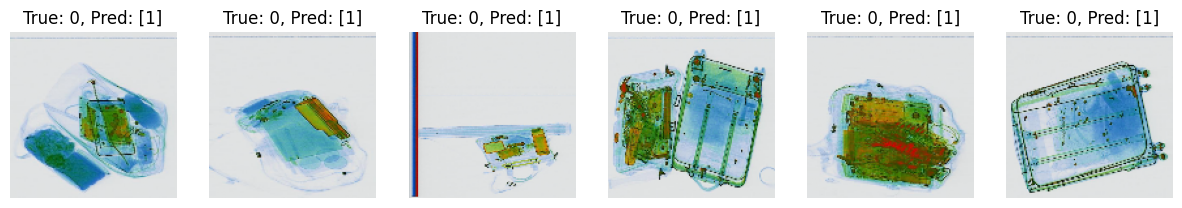

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import json

y_pred = (classification_model.predict(X_test) > 0.5).astype('int32')
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Overall Accuracy:", accuracy_score(y_test, y_pred))

# Save classification results to JSON
results = {
    'classification_report': classification_report(y_test, y_pred, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
    'accuracy': accuracy_score(y_test, y_pred)
}

with open('classification_results.json', 'w') as f:
    json.dump(results, f)

# Display output images of classification
def display_classification_results(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i])
        plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
        plt.axis('off')
    plt.show()

# Display some sample images from the test set with their true and predicted labels
display_classification_results(X_test, y_test, y_pred, num_images=6)


# Define the U-Net model for segmentation

In [ ]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Initialize and train the segmentation model

In [ ]:
segmentation_model = unet_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
segmentation_model.summary()

segmentation_checkpoint = ModelCheckpoint('segmentation_model.keras', save_best_only=True, monitor='val_loss')
segmentation_early_stopping = EarlyStopping(monitor='val_loss', patience=10)

segmentation_history = segmentation_model.fit(
    X_train, masks_train,
    validation_data=(X_val, masks_val),
    epochs=50,
    batch_size=16,
    callbacks=[segmentation_checkpoint, segmentation_early_stopping])


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_92[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 64, 64,    │          0 │ conv2d_93[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_32… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_94[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 32, 32,    │          0 │ conv2d_95[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_33… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_96[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 16, 16,    │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_34… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_98[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16, 16,    │          0 │ conv2d_99[0][0]   │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 8, 8, 512) │          0 │ dropout_11[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_35… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_100[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 8, 8,      │          0 │ conv2d_101[0][0]

 Total params: 31,032,837 (118.38 MB)

 Trainable params: 31,032,837 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-06-19 20:32:45.403051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12288: 3.16341, expected 2.72723
2024-06-19 20:32:45.403132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12416: 3.00427, expected 2.56808
2024-06-19 20:32:45.403160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 4.67983, expected 3.93377
2024-06-19 20:32:45.403169: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16385: 6.45374, expected 5.70769
2024-06-19 20:32:45.403177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16386: 6.1411, expected 5.39504
2024-06-19 20:32:45.403185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16387: 5.93718, expected 5.19113
2024-06-19 20:32:45.403193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16388: 4.45506, expected 3.70901
2024-06-19 20:32:45.403202: 

109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9343 - loss: 0.0628

2024-06-19 20:33:28.418663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 4.04483, expected 3.29109
2024-06-19 20:33:28.418718: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 6.15577, expected 5.40203
2024-06-19 20:33:28.418734: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 5.53923, expected 4.78549
2024-06-19 20:33:28.418746: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 5.13236, expected 4.37862
2024-06-19 20:33:28.418759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 5.05401, expected 4.30027
2024-06-19 20:33:28.418770: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 4.94186, expected 4.18812
2024-06-19 20:33:28.418780: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 4.28033, expected 3.52659
2024-06-19 20:33:28.418790:

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9343 - loss: 0.0626

2024-06-19 20:33:46.582887: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16392: 3.5872, expected 3.08209
2024-06-19 20:33:46.582932: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16442: 3.93848, expected 3.43337
2024-06-19 20:33:46.582942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16464: 3.24766, expected 2.74255
2024-06-19 20:33:46.582991: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 25856: 3.98649, expected 3.48138
2024-06-19 20:33:46.583000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26240: 4.04367, expected 3.53857
2024-06-19 20:33:46.583009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26533: 4.03924, expected 3.53413
2024-06-19 20:33:46.583024: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28544: 3.11223, expected 2.60713
2024-06-19 20:33:46.583033: 

110/110 ━━━━━━━━━━━━━━━━━━━━ 76s 361ms/step - accuracy: 0.9344 - loss: 0.0625 - val_accuracy: 0.9351 - val_loss: 51.2094
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9306 - loss: 7.6776 - val_accuracy: 0.9377 - val_loss: 0.6030
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9370 - loss: 0.5883 - val_accuracy: 0.9377 - val_loss: 0.5473
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9371 - loss: 0.5347 - val_accuracy: 0.9377 - val_loss: 0.4989
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9364 - loss: 0.4881 - val_accuracy: 0.9377 - val_loss: 0.4573
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9364 - loss: 0.4478 - val_accuracy: 0.9377 - val_loss: 0.4206
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9401 - loss: 0.4121 - val_accuracy: 0.9377 - val_loss: 0.3878
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9369 - loss: 0.3803 - va

# Load best model

In [ ]:
segmentation_model.load_weights('segmentation_model.keras')

# Evaluate segmentation model

In [ ]:
\import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

# Assuming segmentation_model and X_test are defined
masks_pred = segmentation_model.predict(X_test)

# Convert predicted masks to binary
masks_pred_binary = (masks_pred > 0.5).astype(np.uint8)

# Ensure masks_test is binary as well
masks_test_binary = (masks_test > 0.5).astype(np.uint8)

# Flatten the masks to compute the F1 score
dice_scores = [f1_score(masks_test_binary[i].flatten(), masks_pred_binary[i].flatten()) for i in range(len(masks_test))]
mean_dice = np.mean(dice_scores)

print("Mean Dice Coefficient:", mean_dice)

# Assuming y_test and y_pred are defined for classification metrics
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred).tolist()
accuracy = accuracy_score(y_test, y_pred)

# Print all values
print("Classification Report:")
print(json.dumps(classification_rep, indent=4))

print("Confusion Matrix:")
print(conf_matrix)

print("Accuracy:", accuracy)

results = {
    'classification_report': classification_rep,
    'confusion_matrix': conf_matrix,
    'accuracy': accuracy,
    'mean_dice': mean_dice
}


ValueError: Input 0 of layer "functional_17" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(10, 256, 256, 3)

# Save results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
